### Using FBProphet Times Series for Walmart Sales Data

This notebook goes into how to optimize a time series analysis of Walamart sales data. I mostly focus on how to optimize using seasonality and adding holidays. Sales data is slightly different from other trend data in that each month there is a mini trend as well.

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

### Defining error 

The two functions below are used to determine what optimizations work the best in providing a good approximation to the time series. The mape function stands for Mean Absolute Percentage Error. The make_comparison_dataframe function creates a dataframe that has the actual values as well as the predicted values.

In [3]:
def mape(y_true,y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

In [4]:
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))


## Data cleaning

In [5]:
features = pd.read_csv('/Users/markmartinez/Documents/DS_Projects/walmart_data/features.csv')

In [6]:
stores = pd.read_csv('/Users/markmartinez/Documents/DS_Projects/walmart_data/stores.csv')

In [7]:
sales = pd.read_csv('/Users/markmartinez/Documents/DS_Projects/walmart_data/sales.csv')

In [8]:
features['Date'] = pd.to_datetime(features['Date'])
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-12-02,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-05-03,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [9]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [10]:
sales['Date'] = pd.to_datetime(sales['Date'])

In [11]:
#will only be looking at store 1 for this analysis
features_sm = features[features['Store'] == 1]
stores_sm = stores[stores['Store'] == 1]
sales_sm = sales[sales['Store'] == 1]

In [12]:
sales_sm

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-05-02,24924.50,False
1,1,1,2010-12-02,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-05-03,21827.90,False
...,...,...,...,...,...
10239,1,99,2012-08-31,20.06,False
10240,1,99,2012-07-09,0.05,True
10241,1,99,2012-09-14,0.03,False
10242,1,99,2012-05-10,635.00,False


In [13]:
sales_sm.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
dtype: object

In [14]:
sales_sm.isna().sum()
#There are no NA values in sales_sm

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [15]:
daily_sales_sm = sales_sm.groupby(['Date']).agg({'Store':'mean','Weekly_Sales':'sum'})

In [16]:
daily_sales_sm.head()

,Store,Weekly_Sales
Date,,
2010-01-10,1,1453329.50
2010-02-04,1,1594968.28
2010-02-07,1,1492418.14
2010-02-19,1,1611968.17
2010-02-26,1,1409727.59


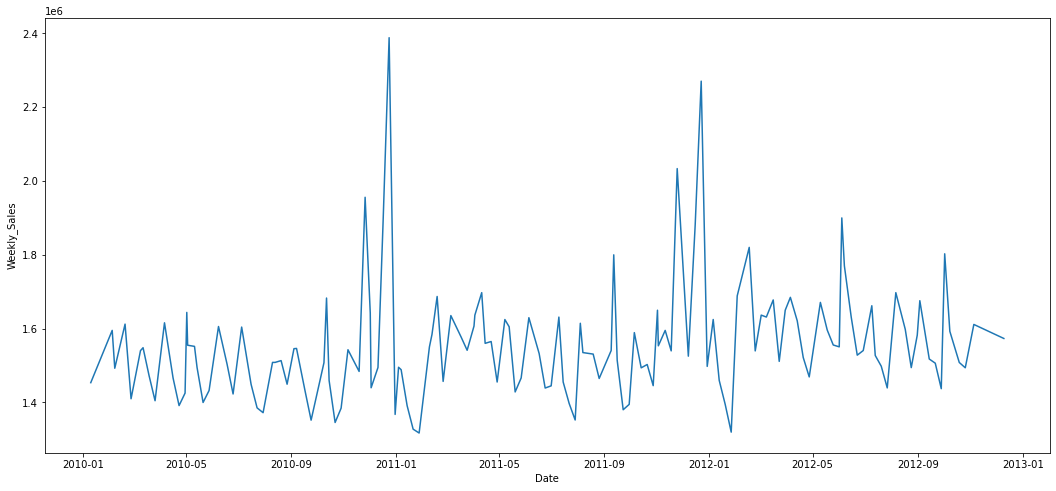

In [17]:
def plot_sales(df):
    plt.figure(figsize=(18,8))
    plt.plot(df['Weekly_Sales'])
    plt.xlabel('Date')
    plt.ylabel('Weekly_Sales')
    plt.grid(False)
    plt.show()


plot_sales(daily_sales_sm)

You can see some definite periodicity here. You see that there is a big spike in Novemeber and December, and that there is a general dip and spike in products throughout each month. You can also see that there is a general upwards trend going up across time.

## Using Prophet

I'll be creating a baseline without any optimizations. This will allow me to see what optimizations provide better MAPE values.

In [18]:
df = daily_sales_sm.reset_index()
df.drop(['Store'],axis=1, inplace=True)
df.head()

,Date,Weekly_Sales
0,2010-01-10,1453329.50
1,2010-02-04,1594968.28
2,2010-02-07,1492418.14
3,2010-02-19,1611968.17
4,2010-02-26,1409727.59


In [19]:
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2010-01-10,1453329.50
1,2010-02-04,1594968.28
2,2010-02-07,1492418.14
3,2010-02-19,1611968.17
4,2010-02-26,1409727.59


In [20]:
prediction_size = 60
train_df = df[:-prediction_size]

This function prints a graph of the actual values vs the predicted values as well as a MAPE. 

In [40]:
def seasonality(vals, holidays = None):
    if holidays is None:
        print('not in holiday')
        m = Prophet(daily_seasonality=False, weekly_seasonality=False,yearly_seasonality=False)
        for val in vals:
            m.add_seasonality(name=val[0], period=val[1], fourier_order=val[2])
    else:
        print('in holiday')
        m = Prophet(holidays =holidays, daily_seasonality=False, weekly_seasonality=False,yearly_seasonality=False)
        for val in vals:
            print('in holiday loop')
            m.add_seasonality(name=val[0], period=val[1], fourier_order=val[2])
            
    print('made it here')
    m.fit(train_df)
    future = m.make_future_dataframe(periods=36, freq='m')
    forecast = m.predict(future)
    
    print('now here')
    plt.figure(figsize=(17, 8))
    plt.plot(forecast['ds'], forecast['yhat'], label='prediction')
    plt.plot(df['ds'], df['y'], label='actual')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Weekly Sales')
    plt.grid(False)
    #plots a line where the training data ends
    plt.axvline(x=train_df['ds'].iloc[-1], color='r', alpha=0.6)
    plt.show()
    
    cmp_df = make_comparison_dataframe(df, forecast)
    cmp_df = cmp_df[cmp_df['y'].notnull()]
    print('MAPE Results ' + str(mape(cmp_df.y,cmp_df.yhat)))    
    

The below does the same thing as the function above, but shows intermediary steps. This is going to output the baseline MAPE to beat.

In [22]:
m = Prophet()
m.fit(train_df)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
future = m.make_future_dataframe(periods=36, freq='m')

forecast = m.predict(future)

In [26]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
114,2014-04-30,1.694476e+06,1.490742e+06,1.847193e+06,1.690253e+06,1.697997e+06,-28889.913353,-28889.913353,-28889.913353,-28889.913353,-28889.913353,-28889.913353,0.0,0.0,0.0,1.665586e+06
115,2014-05-31,1.697516e+06,1.486503e+06,1.861175e+06,1.693089e+06,1.701231e+06,-25326.240833,-25326.240833,-25326.240833,-25326.240833,-25326.240833,-25326.240833,0.0,0.0,0.0,1.672189e+06
116,2014-06-30,1.700457e+06,1.583261e+06,1.938357e+06,1.695834e+06,1.704335e+06,56213.554170,56213.554170,56213.554170,56213.554170,56213.554170,56213.554170,0.0,0.0,0.0,1.756671e+06
117,2014-07-31,1.703497e+06,1.571765e+06,1.931833e+06,1.698698e+06,1.707529e+06,48502.360619,48502.360619,48502.360619,48502.360619,48502.360619,48502.360619,0.0,0.0,0.0,1.751999e+06
118,2014-08-31,1.706536e+06,1.538231e+06,1.901290e+06,1.701519e+06,1.710740e+06,13958.740203,13958.740203,13958.740203,13958.740203,13958.740203,13958.740203,0.0,0.0,0.0,1.720495e+06


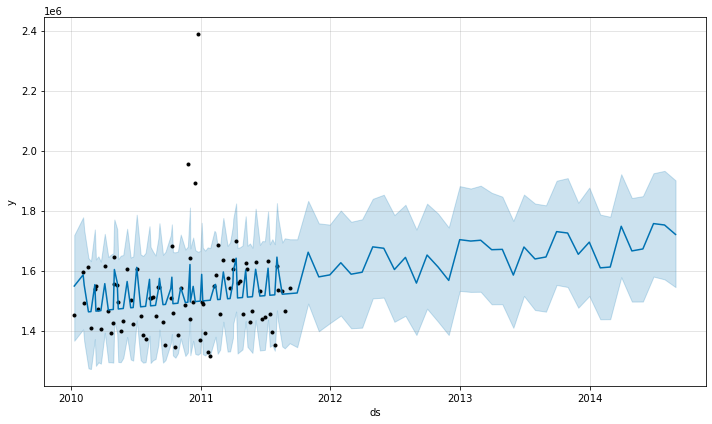

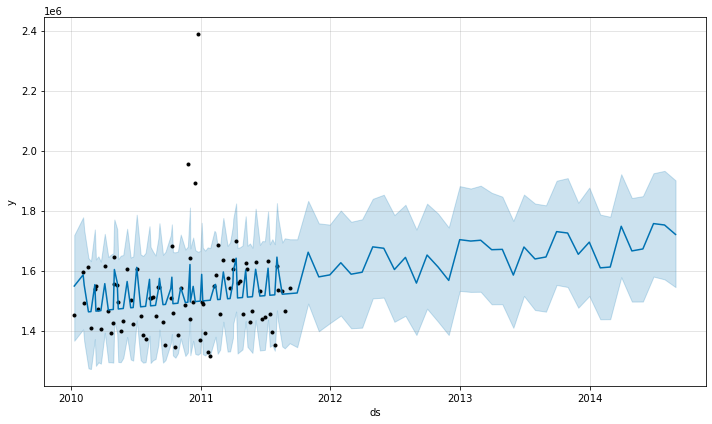

In [24]:
m.plot(forecast)

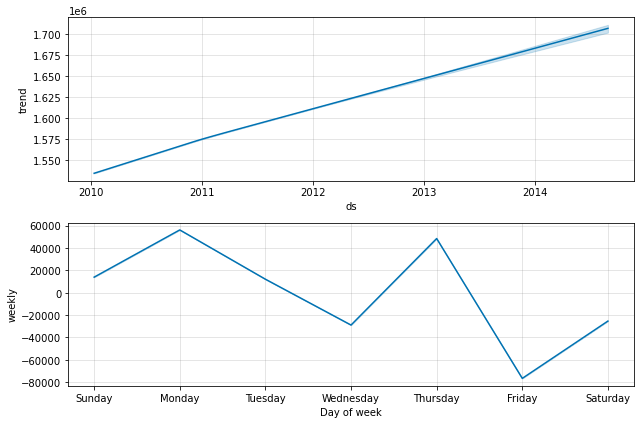

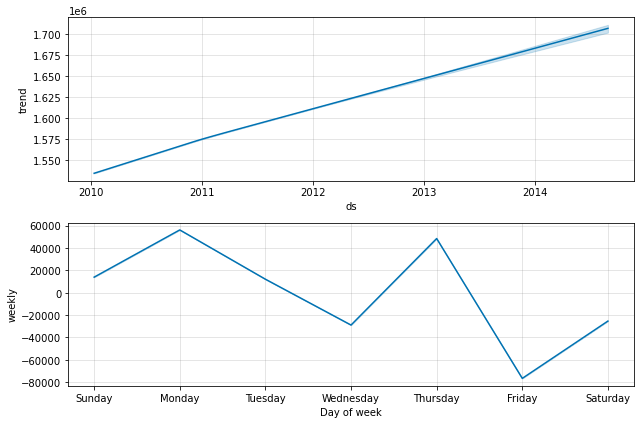

In [28]:
m.plot_components(forecast)

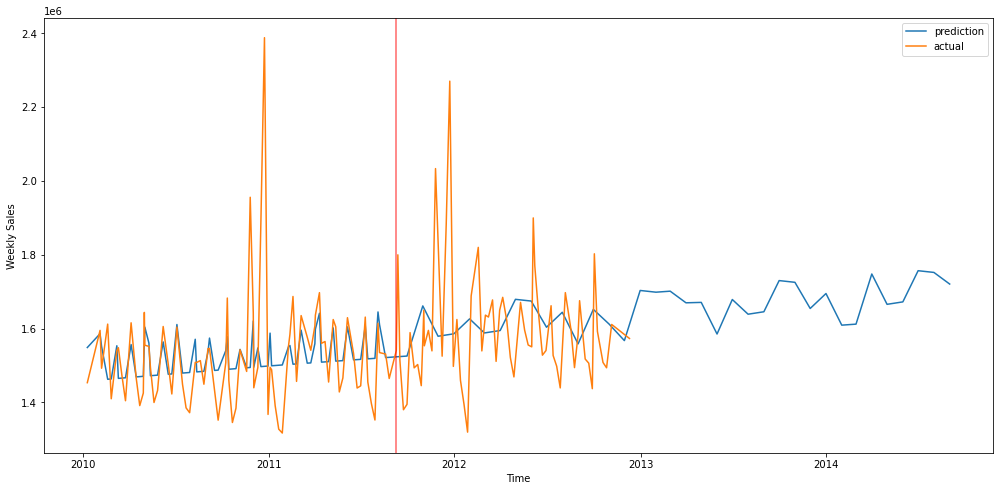

In [25]:
plt.figure(figsize=(17, 8))
plt.plot(forecast['ds'], forecast['yhat'], label='prediction')
plt.plot(df['ds'], df['y'], label='actual')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Weekly Sales')
plt.grid(False)
plt.axvline(x=train_df['ds'].iloc[-1], color='r', alpha=0.6)
plt.show()

In [50]:
mape_baseline = mape(cv_results.y, cv_results.yhat)
print(mape_baseline)

10.414802030723266


We see that without any optimizations we get a MAPE of 10.41%. <b> The red line shows when the training set ends </b>. Looking at the above graph shows that we do not capture the full complexity of the monthly variation, but it does an ok job of simulating a spike each month. It does not quite show the dip. It also can't quite figure out what to do with the big spike in December and the preceding month for black friday.

not in holiday
made it here
now here


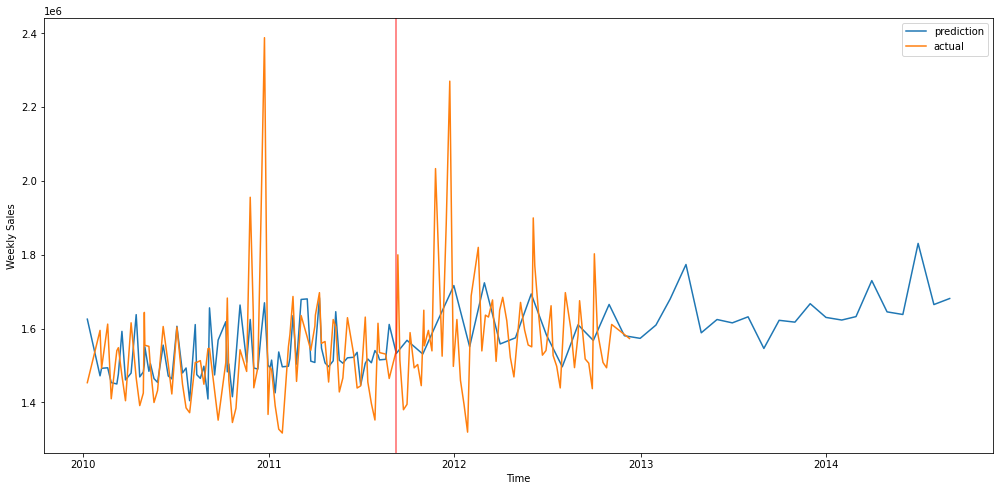

MAPE Results 5.68312409833802


In [26]:
seasonality([['yearly', 12, 20]])

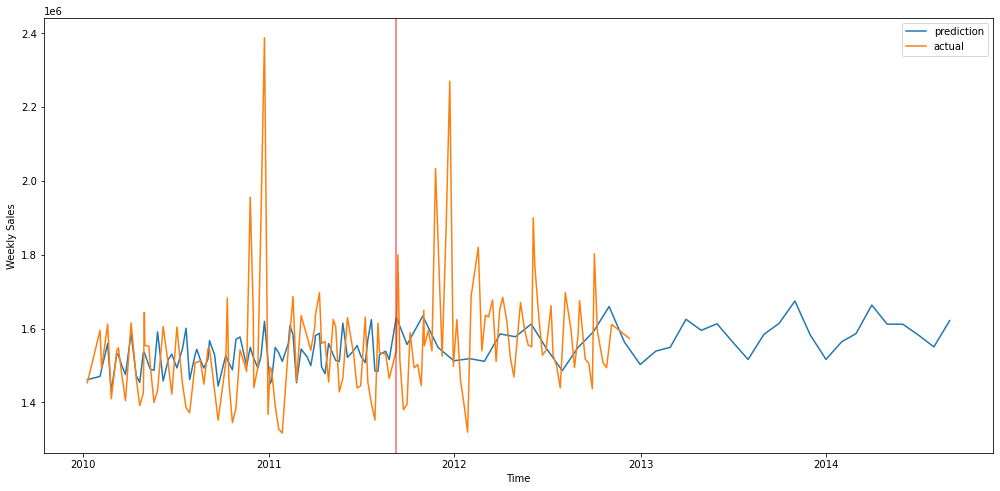

MAPE Results 5.860689196666038


In [40]:
seasonality([['weekly', 52, 3]])

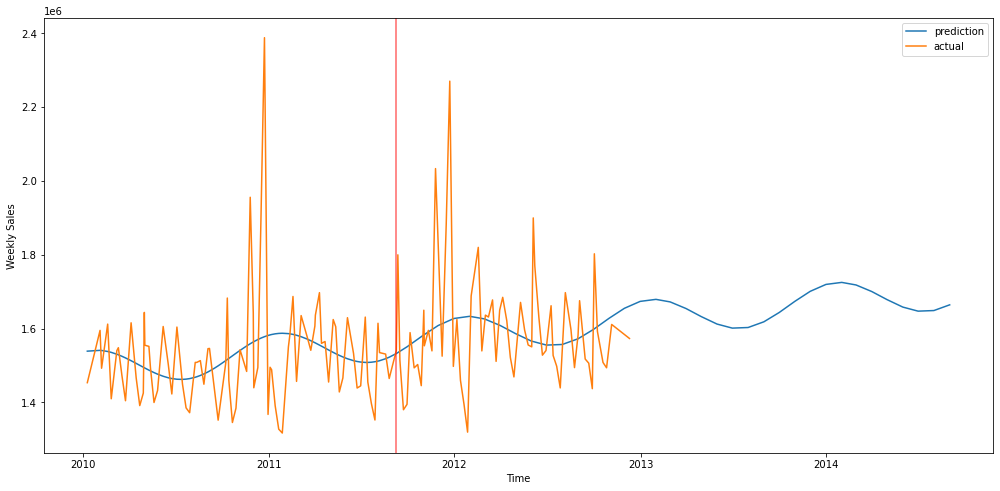

MAPE Results 6.023844991501149


In [41]:
seasonality([['daily', 365, 1]])

The results of just optimizing on one time frame shows that the yearly time frame performs the best, though all of the optimizations outperform the default. The yearly is able to better capture the monthly rises and falls. Next we look at combining the optimizations.

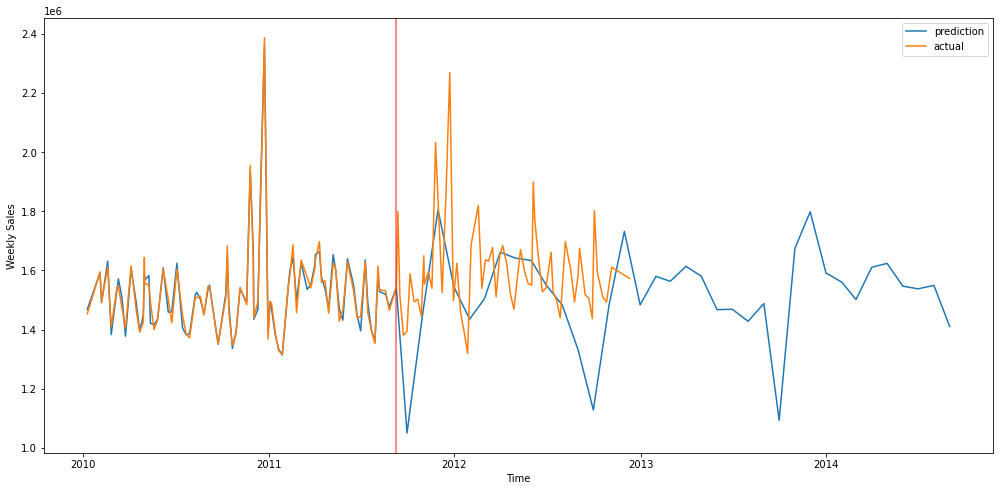

MAPE Results 1.6375124211514496


In [42]:
params = [['monthly',30.5,12],['daily',1,15],['weekly',7,20],['yearly',365.25,20]]
seasonality(params)

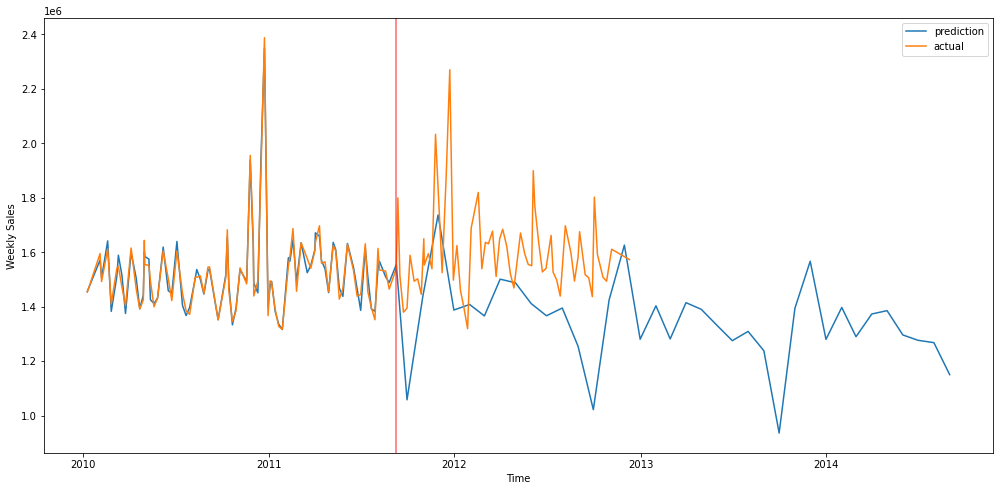

MAPE Results 1.9891528210363723


In [43]:
params = [['monthly',30.5,12],['yearly',365.25,20]]
seasonality(params)

We see that combining multiple optimizations provides the best results for the data including the training set. And the MAPE results are much lower than the other optimizations, but if you look at the predicted graph, it seems as if that the predicted value undershoots the general trend. So in a sense, it makes it seem as if the less specific optimizations actually do a better job of generalizing the market data.

### Adding holidays

Now we're going to be adding holidays. I've included Christmas and Thanksgiving (black friday) which are the big holidays that affects sales the most as well as a lower window that should indicate the effects of it start far before the holiday itself.

In [42]:
holidays = pd.DataFrame({
  'holiday': ['Thanksgiving','Christmas','Thanksgiving','Christmas','Thanksgiving','Christmas'],
  'ds': pd.to_datetime(['2010-11-25','2010-12-25','2012-11-24',
                        '2011-12-25','2012-11-22','2012-12-25']),
  'lower_window': -30,
  'upper_window': 0,
})


In [43]:
holidays

,holiday,ds,lower_window,upper_window
0,Thanksgiving,2010-11-25,-30,0
1,Christmas,2010-12-25,-30,0
2,Thanksgiving,2012-11-24,-30,0
3,Christmas,2011-12-25,-30,0
4,Thanksgiving,2012-11-22,-30,0
5,Christmas,2012-12-25,-30,0


We'll be testing both yearly and the one that includes all of the optimzations

in holiday
in holiday loop
in holiday loop
in holiday loop
in holiday loop
made it here
now here


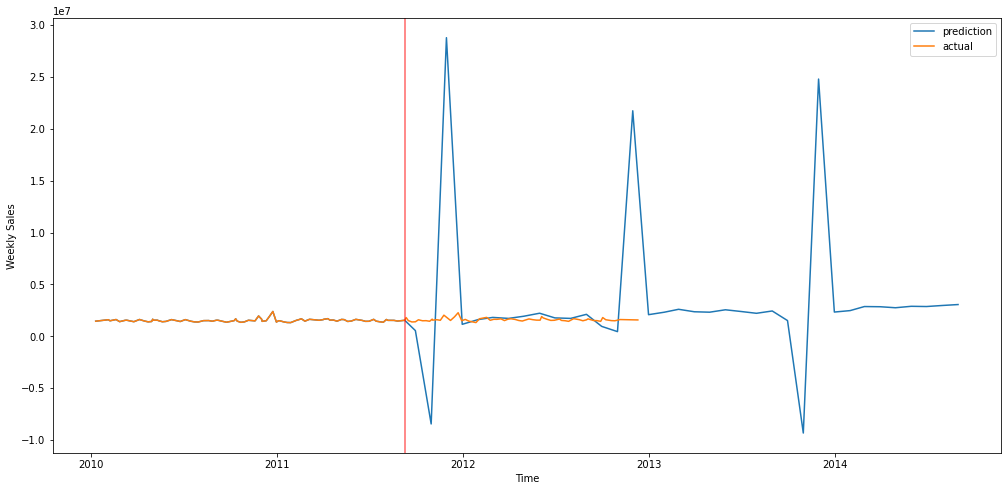

MAPE Results 1.1115395127377334


In [38]:
params = [['monthly',30.5,12],['daily',1,15],['weekly',7,20],['yearly',365.25,20]]
seasonality(params, holidays=holidays)

in holiday
in holiday loop
made it here
now here


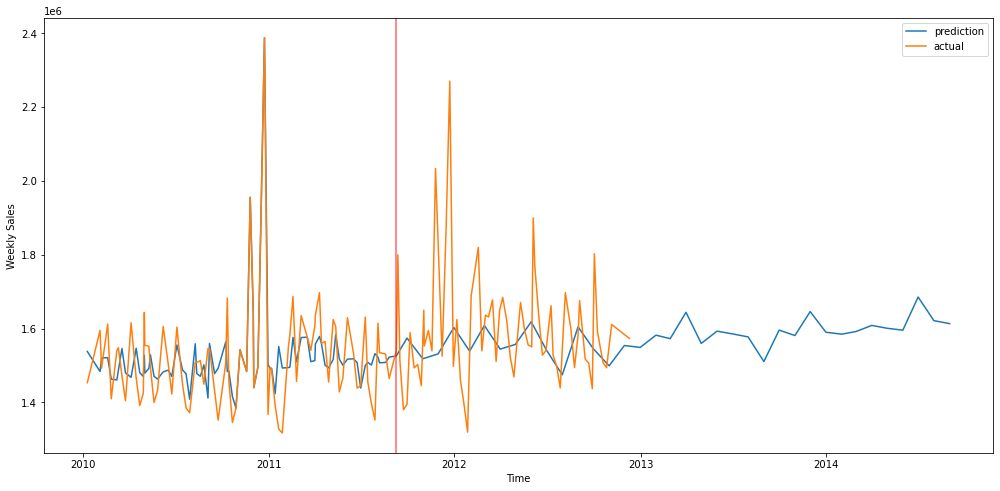

MAPE Results 4.2401263863971534


In [36]:
seasonality([['yearly',12,20]], 
            holidays=holidays)

Surprisingly, adding the holiday had a major effect on making overfitting the data when I specified all of the seasonalities. However, when I just used year, the data generalized better, though still didn't have quite the right fit for the high outlier months of December and November.